In [11]:
from pathlib import Path

TRAIN_MANIFEST = "data/manifests/irmas_train_mels.csv"

EPOCHS       = 500
BATCH_SIZE   = 128
LR           = 1e-3
WEIGHT_DECAY = 1e-4
VAL_FRAC     = 0.15
DROPOUT      = 0.3
PATIENCE     = 100
NUM_WORKERS  = 0 
SEED = 1337

RESUME = False # loads previous model weights, set to False if training from scratch
TRAIN_NUMBER = "train_6" # directory to add  weights, change on each training run
CKPT_DIR = Path(f"saved_weights/irmas_pretrain_single_class/{TRAIN_NUMBER}")
RESUME_CKPT = (CKPT_DIR / "last.pt") if RESUME else None  # or CKPT_DIR/"best_val_acc.pt"

In [12]:
from src.utils.datasets import SingleClassMelNpyDataset
from train_utils import train_loop
out = train_loop(
    train_manifest=TRAIN_MANIFEST,
    ckpt_dir=CKPT_DIR,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    lr=LR,
    weight_decay=WEIGHT_DECAY,
    val_frac=VAL_FRAC,
    dropout=DROPOUT,
    patience=PATIENCE,
    num_workers=NUM_WORKERS,
    seed=SEED,
    resume_from=RESUME_CKPT,
    save_best_stamped=True,
)
history = out["history"]

e:\qingchaolaopian\Instrument Sound\Github\ML-based-analysis-of-sound\train_utils.py:27: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler(enabled=use_cuda_amp)
e:\qingchaolaopian\Instrument Sound\Github\ML-based-analysis-of-sound\train_utils.py:140: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Device: cuda
train size: 5699  val size: 1006
Classes: {'cel': 0, 'cla': 1, 'flu': 2, 'gac': 3, 'gel': 4, 'org': 5, 'pia': 6, 'sax': 7, 'tru': 8, 'vio': 9, 'voi': 10}
Starting fresh.
[001/500] train 2.2316/0.2109 | val 2.0673/0.2763 | time 6.4s
  ↑ new best val_acc: 0.2763
[002/500] train 2.0396/0.2771 | val 1.9153/0.3648 | time 6.4s
  ↑ new best val_acc: 0.3648
[003/500] train 1.9246/0.3216 | val 1.8530/0.3847 | time 9.3s
  ↑ new best val_acc: 0.3847
[004/500] train 1.8156/0.3616 | val 1.7713/0.3926 | time 8.8s
  ↑ new best val_acc: 0.3926
[005/500] train 1.7377/0.3966 | val 1.7348/0.4006 | time 8.8s
  ↑ new best val_acc: 0.4006
[006/500] train 1.6787/0.4132 | val 1.5879/0.4732 | time 9.0s
  ↑ new best val_acc: 0.4732
[007/500] train 1.6197/0.4492 | val 1.5369/0.4751 | time 8.9s
  ↑ new best val_acc: 0.4751
[008/500] train 1.5516/0.4659 | val 1.5389/0.4920 | time 8.8s
  ↑ new best val_acc: 0.4920
[009/500] train 1.5153/0.4810 | val 1.4661/0.5099 | time 9.1s
  ↑ new best val_acc: 0.509

['train_loss', 'train_acc', 'val_loss', 'val_acc']


C:\Users\hu_ju\AppData\Local\Temp\ipykernel_48316\3621404636.py:8: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ckpt_loaded = torch.load(CKPT, map_location="cpu")


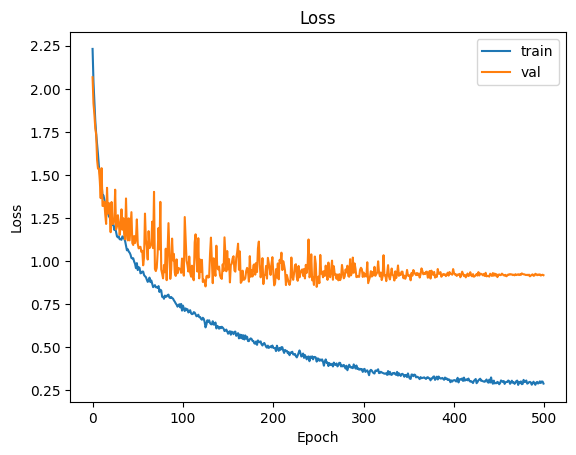

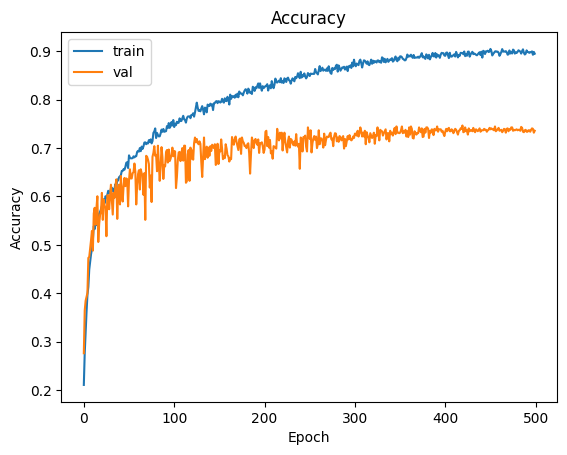

In [13]:

import matplotlib.pyplot as plt
import torch


CKPT = RESUME_CKPT = (CKPT_DIR / "last.pt")
# CKPT = 'saved_weights/irmas_pretrain_single_class/train_1/best_val_acc_junran_0.72.pt' # example of loading a different checkpoint

ckpt_loaded = torch.load(CKPT, map_location="cpu")
history = ckpt_loaded["history"]
print(list(history.keys()))  



plt.figure()
plt.plot(history["train_loss"], label="train")
plt.plot(history["val_loss"], label="val")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Loss"); plt.legend(); plt.show()

plt.figure()
plt.plot(history["train_acc"], label="train")
plt.plot(history["val_acc"], label="val")
plt.xlabel("Epoch") 
plt.ylabel("Accuracy")
plt.title("Accuracy"); plt.legend(); plt.show()

In [ ]:
from pathlib import Path
import torch, numpy as np, matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
from src.models import CNNVarTime
from train_utils import seed_everything, build_dataloaders

device = 'cpu'
pin_mem = False

label_to_idx = ckpt_loaded["label_to_idx"]
idx_to_label = [c for c, i in sorted(label_to_idx.items(), key=lambda kv: kv[1])]
num_classes = len(idx_to_label)

# rebuild val loader with same mapping (same split via same seed) 
_, val_loader, _ = build_dataloaders(
    manifest_csv=TRAIN_MANIFEST,
    val_frac=VAL_FRAC,
    batch_size=BATCH_SIZE,
    num_workers=NUM_WORKERS,
    pin_memory=pin_mem,
    seed=SEED,
    label_to_idx=label_to_idx,  
)

#  build model and load weights (strict) 
model = CNNVarTime(in_ch=2, num_classes=num_classes, p_drop=0.5).to(device)
model.load_state_dict(ckpt_loaded["model_state"], strict=True)
model.eval()

# predict validation set
all_y_true, all_y_pred = [], []
with torch.no_grad():
    for X, y in val_loader:
        X = X.to(device, non_blocking=pin_mem)
        logits = model(X)
        preds = torch.argmax(logits, dim=1).cpu().numpy()
        all_y_pred.extend(preds)
        all_y_true.extend(y.numpy())


cm = confusion_matrix(all_y_true, all_y_pred, labels=list(range(num_classes)))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=idx_to_label)
fig, ax = plt.subplots(figsize=(8, 8))
disp.plot(cmap="Blues", ax=ax, colorbar=False, xticks_rotation=90)
ax.set_title("Validation Confusion Matrix")
plt.tight_layout(); plt.show()

# ---- classification report ----
print(classification_report(all_y_true, all_y_pred, target_names=idx_to_label, digits=4))

ImportError: cannot import name 'get_device_and_amp' from 'train_utils' (e:\qingchaolaopian\Instrument Sound\Github\ML-based-analysis-of-sound\train_utils.py)